## Exploração dos dados de mesnagem antes do pre-processamento

In [4]:
import pandas as pd
import re
#import gensim
import numpy as np
#from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial import distance

In [5]:
#setting parameters for data visualization
np.set_printoptions(threshold=None, precision=2)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('precision', 2)

### Opening movie reviews

In [12]:
messages = pd.read_csv('./chatdata/movie_lines_normalized.tsv', header = None, delimiter="\t", quoting=3, encoding='ISO-8859-2')

In [13]:
messages.columns = ['msg_line', 'user_id', 'movie_id', 'msg']

In [14]:
messages.head(10)

,msg_line,user_id,movie_id,msg
0,L1045,u0,m0,They do not!
1,L1044,u2,m0,They do to!
2,L985,u0,m0,I hope so.
3,L984,u2,m0,She okay?
4,L925,u0,m0,Let's go.
5,L924,u2,m0,Wow
6,L872,u0,m0,Okay -- you're gonna need to learn how to lie.
7,L871,u2,m0,No
8,L870,u0,m0,"""""""I'm kidding. You know how sometimes you jus..."
9,L869,u0,m0,Like my fear of wearing pastels?


### Print profile
- there are some duplicated messages

In [9]:
from pandas_profiling import ProfileReport

In [10]:
profile = ProfileReport(messages, title="Pandas Profiling Report")

In [11]:
profile

### Data exploration

In [6]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304713 entries, 0 to 304712
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   msg_line  304713 non-null  object
 1   user_id   304713 non-null  object
 2   movie_id  304713 non-null  object
 3   msg       304713 non-null  object
dtypes: object(4)
memory usage: 9.3+ MB


In [7]:
messages.describe()

,msg_line,user_id,movie_id,msg
count,304713,304713,304713,304713
unique,304713,9035,659,265277
top,L595224,u4525,m289,What?
freq,1,537,1530,1679


#### Data Analysis based on this article
- https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools?utm_source=medium&utm_medium=crosspost&utm_campaign=blog-exploratory-data-analysis-natural-language-processing-tools

In [8]:
data = messages['msg']

### Number of characters of each message
- The number of characters are between 0 and 500
- The majority is in 0 to 250

<AxesSubplot:>

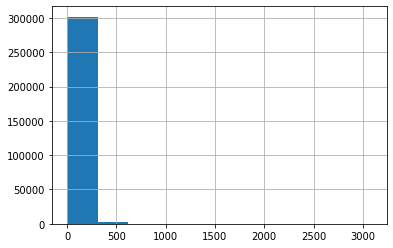

In [9]:
#histogram to display the number of character of each message
data.str.len().hist()

## Value types
- all valuesare strings

In [10]:
#checking the average word length
data_set = [type(item) for item in data]
data_set = set(data_set)
data_set

{str}

## Print float values

In [11]:
float_val = [it for it in data if isinstance(it, float)]
print(len(float_val))
float_val = set(float_val)
print(float_val)

0
set()


In [12]:
messages[messages['msg'].isna()]

,msg_line,user_id,movie_id,msg


### Removing non-alphabetical messages (not used)

### Number of words for each message
- The number of words are between 0 and 1000
- the majority is in 0 to 500

<AxesSubplot:>

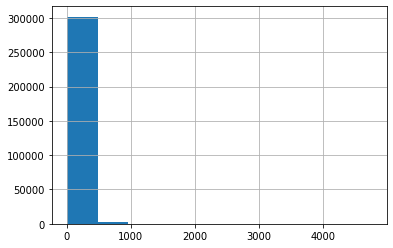

In [15]:
#number of words for each message
data.str.split(' ').\
    map(lambda x: len(str(x))).\
    hist()

### Average word length
- The length of words goes from 0 to 15

<AxesSubplot:>

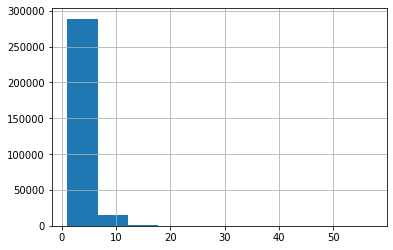

In [16]:
#checking the average word length
data.str.split(' ').\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

### Distribuition of stopwords in the mesages
- the most frequent stopwords are 'you', 'the' and 'to', so the messages seems to be informal conversations

In [17]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/douglas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
#checkig the distribuition of stopwrds in the mesages
stop=set(stopwords.words('english'))
corpus=[]
msg_ = data.str.split()
msg_ = msg_.values.tolist()
corpus=[word for i in msg_ for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

In [19]:
len(list(dic.values()))

164

In [20]:
import matplotlib.pyplot as plt

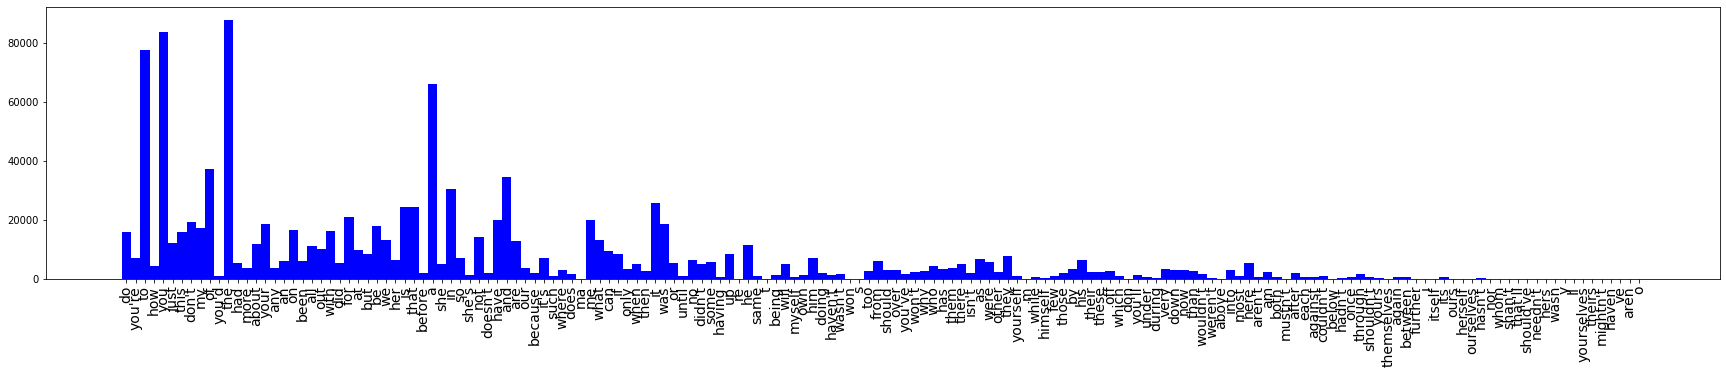

In [21]:
x = dic.keys()
y = dic.values()
plt.subplots(figsize=(30,5))
plt.bar(x, y, 1, color='b')
plt.xticks(list(x), rotation=90, fontsize=14)
plt.show()

The majority of stop words are 'to', 'you', 'the' and 'a'

### Occurences of each word
- the words 'I' and 'you' are the most common enforcing the idea of informal conversations

In [22]:
from collections import Counter
import seaborn as sns

<AxesSubplot:>

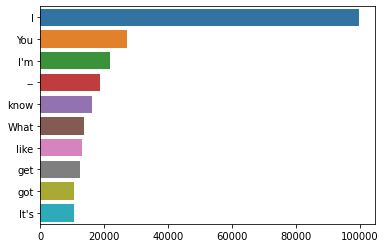

In [23]:
#ploting the occurences of each word
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

The word 'I' has the biggest occurrence. There are a lot of messages like dashes that can be removed

### Get the most frequent n-grams
- all n-grams are form informal conversations

In [24]:
from nltk.util import ngrams

In [25]:
#get the most frequent n-grams
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

In [26]:
def plot_n_gram(corpus, n=2):
    top_n_bigrams=get_top_ngram(corpus,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

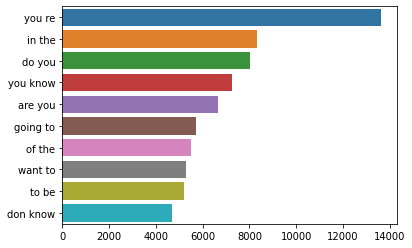

In [27]:
plot_n_gram(data, 2)

The more frequent bigram is 'you re'

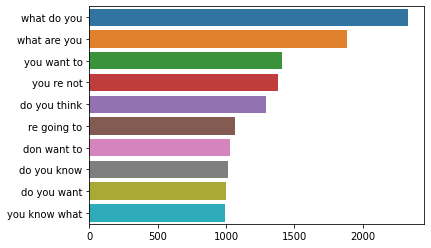

In [28]:
plot_n_gram(data, 3)

There are a lot of short questions like 'what do you...?', 'what are you...?', and answers like 'you want to...'

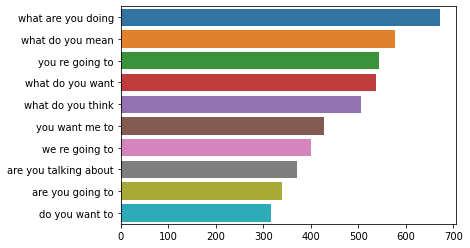

In [29]:
plot_n_gram(data, 4)

There are a lot of repeated questions and answers or part of them

### Sentimental analysis
- the majority of the messages are neutral (close to 0), but there is a small number of negative (close to -1) and positive (close to 1) ones

In [30]:
from textblob import TextBlob

In [31]:
#checkig the polarity of the messages
def polarity(text):
    return TextBlob(text).sentiment.polarity

<AxesSubplot:>

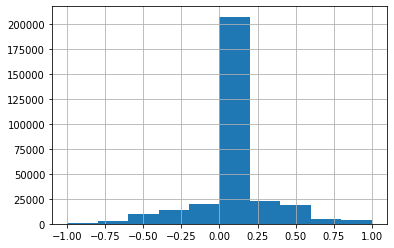

In [32]:
messages['polarity_score']=data.\
   apply(lambda x : polarity(x))
messages['polarity_score'].hist()

The majority of polarity is neutral

### Named entity recognition

- TYPE	DESCRIPTION
- PERSON	People, including fictional.
- NORP	Nationalities or religious or political groups.
- FAC	Buildings, airports, highways, bridges, etc.
- ORG	Companies, agencies, institutions, etc.
- GPE	Countries, cities, states.
- LOC	Non-GPE locations, mountain ranges, bodies of water.
- PRODUCT	Objects, vehicles, foods, etc. (Not services.)
- EVENT	Named hurricanes, battles, wars, sports events, etc.
- WORK_OF_ART	Titles of books, songs, etc.
- LAW	Named documents made into laws.
- LANGUAGE	Any named language.
- DATE	Absolute or relative dates or periods.
- TIME	Times smaller than a day.
- PERCENT	Percentage, including ”%“.
- MONEY	Monetary values, including unit.
- QUANTITY	Measurements, as of weight or distance.
- ORDINAL	“first”, “second”, etc.
- CARDINAL	Numerals that do not fall under another type.

In [15]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [16]:
#transform the messages in a big document
def get_entities(corpus, int_limit=0, end_limit=100):
    msg_all = ' '.join(data[int_limit:end_limit])
    doc = nlp(msg_all)

    entity_list = [(x.text,x.label_) for x in doc.ents]
    
    return entity_list

In [9]:
%%time

ent_list = set()
ent_list_res = set()
skip = 1000
i = 0
lim = len(data)
#lim = 3000

while(i < lim):    
    ent_list = set(get_entities(data, i, i+skip))
    ent_list_res = ent_list_res.union(ent_list)
    i = i + skip
    print('Processed '+str(i)+' of '+str(lim)+' messages')

Processed 1000 of 304713 messages
Processed 2000 of 304713 messages
Processed 3000 of 304713 messages
Processed 4000 of 304713 messages
Processed 5000 of 304713 messages
Processed 6000 of 304713 messages
Processed 7000 of 304713 messages
Processed 8000 of 304713 messages
Processed 9000 of 304713 messages
Processed 10000 of 304713 messages
Processed 11000 of 304713 messages
Processed 12000 of 304713 messages
Processed 13000 of 304713 messages
Processed 14000 of 304713 messages
Processed 15000 of 304713 messages
Processed 16000 of 304713 messages
Processed 17000 of 304713 messages
Processed 18000 of 304713 messages
Processed 19000 of 304713 messages
Processed 20000 of 304713 messages
Processed 21000 of 304713 messages
Processed 22000 of 304713 messages
Processed 23000 of 304713 messages
Processed 24000 of 304713 messages
Processed 25000 of 304713 messages
Processed 26000 of 304713 messages
Processed 27000 of 304713 messages
Processed 28000 of 304713 messages
Processed 29000 of 304713 mes

Processed 232000 of 304713 messages
Processed 233000 of 304713 messages
Processed 234000 of 304713 messages
Processed 235000 of 304713 messages
Processed 236000 of 304713 messages
Processed 237000 of 304713 messages
Processed 238000 of 304713 messages
Processed 239000 of 304713 messages
Processed 240000 of 304713 messages
Processed 241000 of 304713 messages
Processed 242000 of 304713 messages
Processed 243000 of 304713 messages
Processed 244000 of 304713 messages
Processed 245000 of 304713 messages
Processed 246000 of 304713 messages
Processed 247000 of 304713 messages
Processed 248000 of 304713 messages
Processed 249000 of 304713 messages
Processed 250000 of 304713 messages
Processed 251000 of 304713 messages
Processed 252000 of 304713 messages
Processed 253000 of 304713 messages
Processed 254000 of 304713 messages
Processed 255000 of 304713 messages
Processed 256000 of 304713 messages
Processed 257000 of 304713 messages
Processed 258000 of 304713 messages
Processed 259000 of 304713 m

In [10]:
len(ent_list_res)

39875

In [11]:
ent_list_res

{('Kinda', 'ORG'),
 ('The Dallas Times Herald', 'ORG'),
 ('Queen Louisa', 'PERSON'),
 ('A.M', 'GPE'),
 ('Cousin Hop', 'PERSON'),
 ('Mommy', 'PERSON'),
 ('Madam', 'PRODUCT'),
 ('Uhura', 'NORP'),
 ('71.50', 'MONEY'),
 ('Strachi Cuneo', 'PERSON'),
 ('Marquise Charenton', 'PERSON'),
 ('Frank Patrick Sullivan', 'PERSON'),
 ('Bless America', 'ORG'),
 ('my hundred-forty-five dollars', 'CARDINAL'),
 ('Xerox', 'ORG'),
 ('Raimondo', 'PERSON'),
 ('Falkland', 'ORG'),
 ('Klara', 'PERSON'),
 ('eleven and a half', 'CARDINAL'),
 ('butI', 'PERSON'),
 ('Greaseball Goombahs', 'PRODUCT'),
 ('Funny', 'WORK_OF_ART'),
 ('Alvy Singer', 'PERSON'),
 ('Landon Carter', 'PERSON'),
 ('thirteen-thousand', 'CARDINAL'),
 ('Lillian', 'GPE'),
 ('Gentile', 'PERSON'),
 ("Laura Scudder's", 'PERSON'),
 ('Valerie Doran', 'PERSON'),
 ('Easterners', 'NORP'),
 ("a few minutes '", 'TIME'),
 ('Catherine Laboure', 'PERSON'),
 ('7000', 'MONEY'),
 ('Autodoc', 'ORG'),
 ('some hours', 'TIME'),
 ('" The call I just made?', 'WORK_OF_ART

There are some personal names, real locals, name of organizations and work of art that can be removed or replaced for generic terms. 

In [15]:
ent_df = pd.DataFrame(list(ent_list_res))

In [16]:
ent_df

,0,1
0,Kinda,ORG
1,The Dallas Times Herald,ORG
2,Queen Louisa,PERSON
3,A.M,GPE
4,Cousin Hop,PERSON
...,...,...
39870,a couple of bucks,MONEY
39871,E.J.,GPE
39872,6.6,CARDINAL
39873,Sidalee,PERSON


In [17]:
ent_df.to_csv('./chatdata/entity_list_complete.tsv', index=False, sep='\t', header=False)

### Entity frequency
- the majority of entities is PERSON, so the messages should have name of people. This enforce the idea of daily conversation

In [63]:
def ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]

In [64]:
%%time
#count the number of each entity
ent=data.\
    apply(lambda x : ner(x))
ent=[x for sub in ent for x in sub]

counter=Counter(ent)
count=counter.most_common()

CPU times: user 58min 9s, sys: 4.12 s, total: 58min 13s
Wall time: 58min 44s


<AxesSubplot:>

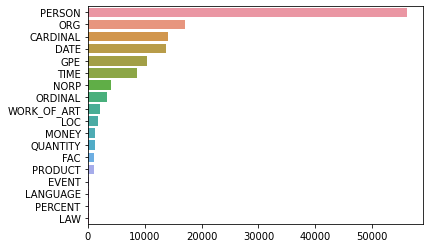

In [65]:
x,y=map(list,zip(*count))
sns.barplot(x=y,y=x)

### Most comon tokens per entity (not used)

In [66]:
def ner(text,ent="PERSON"):
    doc=nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

## Parts of Speach Tagging

There are eight main parts of speech:

- Noun (NN)- Joseph, London, table, cat, teacher, pen, city
- Verb (VB)- read, speak, run, eat, play, live, walk, have, like, are, is
- Adjective(JJ)- beautiful, happy, sad, young, fun, three
- Adverb(RB)- slowly, quietly, very, always, never, too, well, tomorrow
- Preposition (IN)- at, on, in, from, with, near, between, about, under
- Conjunction (CC)- and, or, but, because, so, yet, unless, since, if
- Pronoun(PRP)- I, you, we, they, he, she, it, me, us, them, him, her, this
- Interjection (INT)- Ouch! Wow! Great! Help! Oh! Hey! Hi!

In [ ]:
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize

In [ ]:
def remove_duplicated_spaces(corpus):
    #remove duplicated spaces
    corpus_alt = re.sub(r' +', ' ', corpus)

    return corpus_alt

In [ ]:
msg_no_space = [remove_duplicated_spaces(str(m)) for m in data]
msg_no_space = pd.Series(msg_no_space)

In [ ]:
def pos(text):
    #matched = re.match(r" +", text)
    if text != ' ':
        #print(text)
        pos=nltk.pos_tag(word_tokenize(text))
        #print(pos)
        pos=list(map(list,zip(*pos)))[1]
        return pos
    return

In [ ]:
%%time
tags=msg_no_space[0:5000].apply(lambda x : pos(x))
#tags = [pos(m) for m in msg_no_space[0:10000]]
#tags
tags=[x for l in tags for x in l]
counter=Counter(tags)

In [ ]:
x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

In [ ]:
### most commonly nouns
def get_adjs(text, _tag='PRP'):
    adj=[]
    pos=nltk.pos_tag(word_tokenize(text))
    for word,tag in pos:
        if tag == _tag:
            adj.append(word)
    return adj

In [ ]:
%%time
words=msg.apply(lambda x : get_adjs(x))
words=[x for l in words for x in l]
counter=Counter(words)

In [ ]:
x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

## Text complexy
- The text is easy to read (0-30 college), so it should be a informal conversation indeed

Flesch Reading Ease (FRE)
<br>Higher scores indicate material that is easier to read, lower numbers mark harder-to-read passages:
- 0-30 College
- 50-60 High school
- 60+ Fourth grade

In [17]:
from textstat import flesch_reading_ease

In [19]:
msg = messages['msg']

CPU times: user 28.9 s, sys: 250 ms, total: 29.2 s
Wall time: 29.5 s


<AxesSubplot:>

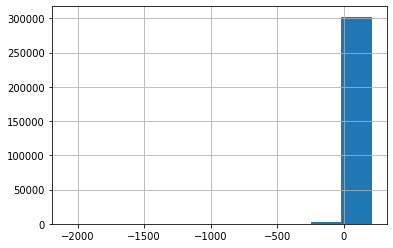

In [20]:
%%time
reading = msg.\
   apply(lambda x : flesch_reading_ease(x))
reading.hist()

In [21]:
x=[i for i in range(len(reading)) if reading[i]<0]

messages.iloc[x]['msg'].head()

97                           Hopefully.
99                           Expensive?
203     Extremely unfortunate maneuver.
258                         Thirty-two.
371    Neither has his heterosexuality.
Name: msg, dtype: object